In [1]:
%matplotlib inline

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from random import randint
from collections import Counter
from scipy.misc import toimage

In [3]:
def get_disparity_matrix(left_image, right_image):
    lengthL, widthL, heightL = left_image.shape
    lengthR, widthR, heightR = right_image.shape

    window_size = 40
    disparity_matrix = np.zeros((left_image.shape[0], left_image.shape[1] - window_size))
    for i in range(lengthR):
        for j in range(widthR - window_size):
            temp = []
            for k in range(j, j + window_size):
                temp.append(np.linalg.norm(right_image[i][j] - left_image[i][k]))
            disparity_matrix[i][j] = np.min(temp)
    return disparity_matrix

In [4]:
def get_means(disparity_matrix):
    k = 3
    centroids = np.empty(k)
    centroids[0] = disparity_matrix[0][1]
    centroids[1] = disparity_matrix[25][36]
    centroids[2] = disparity_matrix[300][300]

    aa = np.empty(k)
    cl = np.empty((disparity_matrix.shape[0], disparity_matrix.shape[1]))
    for i in range(disparity_matrix.shape[0]):
        for j in range(disparity_matrix.shape[1]):
            for ij in range(k):
                aa[ij] = np.sqrt(np.sum((disparity_matrix[i][j] - centroids[ij]) ** 2))
            cl[i][j] = np.argmin(aa)
    print(cl.shape)

    sum1 = sum2 = sum3 = c1 = c2 = c3 = 0
    for i in range(disparity_matrix.shape[0]):
        for j in range(disparity_matrix.shape[1]):
            if cl[i][j] == 0:
                sum1 += disparity_matrix[i][j]
                c1 += 1
            elif cl[i][j] == 1:
                sum2 += disparity_matrix[i][j]
                c2 += 1
            else:
                sum3 += disparity_matrix[i][j]
                c3 += 1
    avg1 = (sum1 / c1)
    avg2 = (sum2 / c2)
    avg3 = (sum3 / c3)

    for i in range(disparity_matrix.shape[0]):
        for j in range(disparity_matrix.shape[1]):
            if cl[i][j] == 0:
                disparity_matrix[i][j] = avg1
            elif cl[i][j] == 1:
                disparity_matrix[i][j] = avg2
            else:
                disparity_matrix[i][j] = avg3
    print(disparity_matrix.shape)

    return disparity_matrix, avg1, avg2, avg3

In [5]:
im0 = Image.open('data/im0.ppm')
im8 = Image.open('data/im8.ppm')
left_image = np.asarray(im0, dtype="int32")
right_image = np.asarray(im8, dtype="int32")

In [6]:
disparity_matrix = get_disparity_matrix(left_image, right_image)
a = np.copy(disparity_matrix)

In [7]:
print(disparity_matrix.shape)

(381L, 390L)


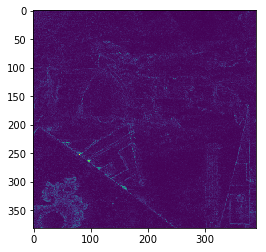

In [8]:
plt.imshow(disparity_matrix)

In [9]:
depth_map, mean1, mean2, mean3 = get_means(a)

(381L, 390L)
(381L, 390L)


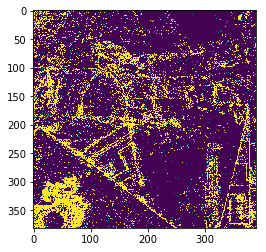

In [10]:
plt.imshow(depth_map)

In [11]:
mean1

6.428046135100721

In [12]:
def fastest_calc_dist(p1, p2):
    return math.sqrt((p2 - p1) ** 2)

In [13]:
def get_label(point, labels):
    labels1 = np.zeros(labels.shape)
    for i in range(len(labels)):
        labels1[i] = fastest_calc_dist(point, labels[i])
    return np.argmin(labels1)

In [14]:
def init_labelling(depth_map, m0, m1, m2):
    labels = np.array([m0, m1, m2])
    label_map = np.zeros(depth_map.shape)
    for i in range(len(depth_map)):
        for j in range(len(depth_map)):
            label_map[i][j] = get_label(depth_map[i][j], labels)
    return label_map

In [15]:
label_map = init_labelling(depth_map, mean1, mean2, mean3)

In [16]:
depth_map.shape

(381L, 390L)

In [17]:
label_map

array([[ 2.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 2.,  2.,  2., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  2.,  2., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 2.,  1.,  1., ...,  0.,  0.,  0.]])

In [18]:
color_bound = np.zeros((381, 390, 3))
for i in xrange(len(label_map)):
    for j in xrange(len(label_map[0])):
        if label_map[i][j] == 0:
            color_bound[i][j][0] = 255
        elif label_map[i][j] == 1:
            color_bound[i][j][1] = 255
        elif label_map[i][j] == 2:
            color_bound[i][j][2] = 255

In [19]:
# toimage(color_bound).save('color_old.jpg')

In [20]:
depth_map

array([[  3.05975739,   6.42804614,  11.76008738, ...,   3.05975739,
          3.05975739,   3.05975739],
       [  6.42804614,  11.76008738,  11.76008738, ...,   3.05975739,
          3.05975739,   3.05975739],
       [  3.05975739,   3.05975739,   3.05975739, ...,   3.05975739,
          3.05975739,   3.05975739],
       ..., 
       [ 11.76008738,   3.05975739,   3.05975739, ...,   3.05975739,
          3.05975739,  11.76008738],
       [ 11.76008738,  11.76008738,  11.76008738, ...,   3.05975739,
          3.05975739,   3.05975739],
       [  3.05975739,  11.76008738,  11.76008738, ...,   3.05975739,
          3.05975739,   3.05975739]])

In [21]:
def get_pixel_label(idx, idy, label_map, depth_map, disparity_matrix, clazz):
    lab_count = Counter()
    if idx > 0 and idy > 0:
        lab_count[label_map[idx - 1][idy - 1]] += 1
    if idx > 0:
        lab_count[label_map[idx - 1][idy]] += 1
        if idy < len(label_map[0])-1:
            lab_count[label_map[idx - 1][idy + 1]] += 1
    if idy > 0:
        lab_count[label_map[idx][idy - 1]] += 1
        if idx < len(label_map)-1:
            lab_count[label_map[idx + 1][idy - 1]] += 1

    if idy < len(label_map[0])-1:
        lab_count[label_map[idx][idy + 1]] += 1
    if idy < len(label_map[0])-1:
        lab_count[label_map[idx][idy + 1]] += 1
        if idx < len(label_map)-1:
            lab_count[label_map[idx + 1][idy + 1]] += 1

    n_prob = np.zeros(len(clazz))
    
    
    total_neigh = float(sum(lab_count.values()))

    for i, j in lab_count.items():
        n_prob[int(i)] = j / total_neigh

    inv_dist = np.zeros(len(clazz))
    for i in xrange(len(clazz)):
        inv_dist[i] = 1/fastest_calc_dist(disparity_matrix[idx][idy], clazz[i])
    sum_dist = sum(inv_dist)
    
    post_probs = n_prob = np.zeros(len(clazz))
    
    for i in xrange(len(inv_dist)):
        post_probs[i] = inv_dist[i]/sum_dist

    prob = np.multiply(n_prob, post_probs)
    return np.argmax(prob)

In [22]:
idx = randint(0, len(depth_map)-1)
idy = randint(0, len(depth_map[0])-1)
idx, idy

(17, 237)

In [23]:
clazz = [mean1, mean2, mean3]

In [24]:
get_pixel_label(idx, idy, label_map, depth_map, disparity_matrix, clazz)

2

In [29]:
for _ in xrange(10):
    for _ in xrange(len(label_map)*len(label_map[0])):
        idx = randint(0, len(depth_map)-1)
        idy = randint(0, len(depth_map[0])-1)
        label_map[idx][idy] = get_pixel_label(idx, idy, label_map, depth_map, disparity_matrix, clazz)

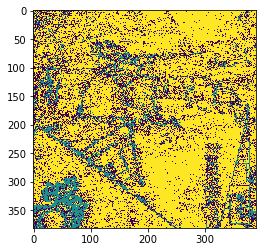

In [30]:
plt.imshow(label_map)

In [31]:
color_bound = np.zeros((381, 390, 3))
for i in xrange(len(label_map)):
    for j in xrange(len(label_map[0])):
        if label_map[i][j] == 0:
            color_bound[i][j][0] = 255
        elif label_map[i][j] == 1:
            color_bound[i][j][1] = 255
        elif label_map[i][j] == 2:
            color_bound[i][j][2] = 255

In [32]:
toimage(color_bound).save('color_new.jpg')